# Imports

In [45]:
import pandas as pd
from lib.constants import *
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import math
from math import pi
import ast
import seaborn as sns
from wordcloud import WordCloud
from statistics import mode
import random
import ternary

os.makedirs(OUTPUT_GRAPHS, exist_ok=True)
SENTIMENT_ANALYSIS_TOOLS = [VADER, AFINN]
FONT_TITLE = 18
FONT_TICKS = 14
#PAULTOL_COLORBLINDPALETTE = ["#332288", "#88ccee", "#44aa99", "#117733", "#999933", "#ddcc77", "#cc6677", "#882255", "#aa4499", "#dddddd"]
PAULTOL_COLORBLINDPALETTE = [
    "#332288", "#88CCEE", "#44AA99", "#117733", "#999933", 
    "#DDCC77", "#CC6677", "#882255", "#AA4499", "#DDDDDD",
    "#661100", "#6699CC", "#AA4466", "#4477AA", "#BBBBBB",
    "#66CCEE", "#EEDD88"
]
MODELS = [BERT_LARGE, LLAMA3_70B, GEMMA3_27B, DEEPSEEK_673B, GPT4, GEMINI_2_0_FLASH]

# Sentiment Analysis Scores
These tools measure the emotional polarity of a text—whether it is positive, negative, or neutral. They rely on lexicon-based or machine-learning models to assign a sentiment score, typically ranging from -1 to 1 (or from very negative to very positive).


## Bar Graph 
Where each model has its own graph, each bar is a different tool and it's comparing the subject categories

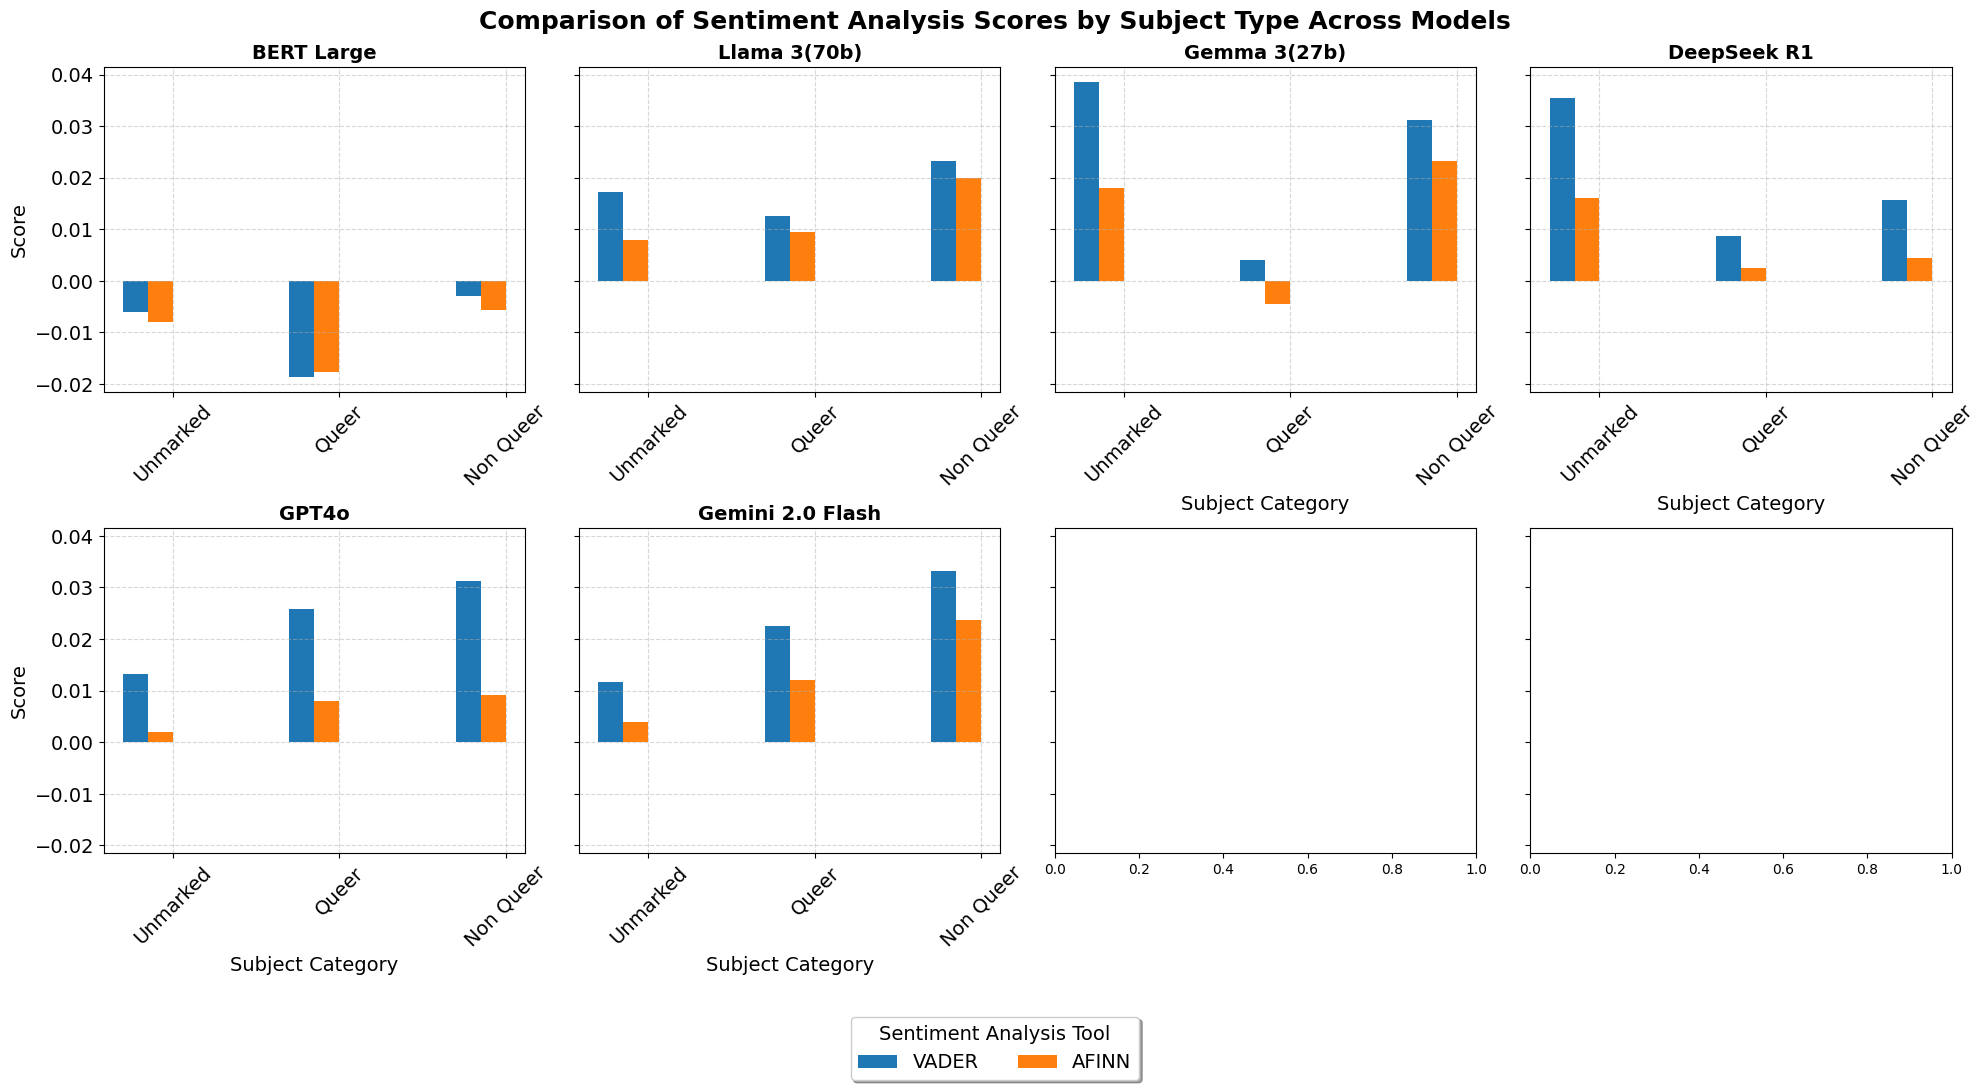

In [46]:
def sentiment_analysis_score(models, errVisible):
    # Determine grid layout: max 4 columns per row
    num_models = len(models)
    num_cols = min(4, num_models)  # Max 4 per row
    num_rows = math.ceil(num_models / num_cols)  # Calculate required rows

    # Create subplots dynamically
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()  # Flatten in case of a single row
    
    all_handles = []
    all_labels = []

    for i, model in enumerate(models):
        ax = axes[i]
        bar_width = 0.15
        
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        mean_scores = df.groupby(TYPE, sort=False)[SENTIMENT_ANALYSIS_TOOLS].mean()
        std_dev = df.groupby(TYPE, sort=False)[SENTIMENT_ANALYSIS_TOOLS].std()
        
        x_labels = mean_scores.index  # Dynamically retrieve category labels
        x = np.arange(len(x_labels))  # Generate correct x positions
        
        for j, tool in enumerate(SENTIMENT_ANALYSIS_TOOLS):
            values = mean_scores[tool].values
            errors = std_dev[tool].values  # Standard deviation as error bars
            if errVisible:
                bars = ax.bar(x + j * bar_width, values, bar_width, label=tool, yerr=errors)  
            else:
                bars = ax.bar(x + j * bar_width, values, bar_width, label=tool)
            
            if i == 0:  # Only store labels once to avoid duplicates
                all_handles.append(bars[0])
                all_labels.append(tool)
        
        ax.set_title(MODELS_LABELS[model], fontsize=FONT_TICKS, fontweight="bold")
        ax.set_xticks(x + (bar_width * 1.5))  # Center labels
        ax.set_xticklabels(mean_scores.index, rotation=45)
        ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
        ax.grid(True, linestyle='--', alpha=0.5)
        
        if (len(models) - i - 4) <= 0:        
            ax.set_xlabel("Subject Category", size=FONT_TICKS)
        
        if (i % 4) == 0:
            ax.set_ylabel("Score", size=FONT_TICKS)
    
    # Global title
    plt.suptitle("Comparison of Sentiment Analysis Scores by Subject Type Across Models", fontsize=FONT_TITLE, fontweight="bold")

    # Adjust bottom margin for legend placement
    plt.subplots_adjust(bottom=0.2)

    # Centralized legend at the bottom
    fig.legend(all_handles, all_labels, title="Sentiment Analysis Tool", loc="lower center", bbox_to_anchor=(0.5, -0.10), fancybox=True, shadow=True, ncol=len(SENTIMENT_ANALYSIS_TOOLS), fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)

    plt.tight_layout()
    #plt.show()
    plt.savefig(OUTPUT_GRAPHS+'SA_barGraph.png', bbox_inches = 'tight')
    
sentiment_analysis_score(MODELS, False)

## Stacked Bar Graph 
Where each model has its own graph, each bar shows the scores on the tools stucked and it's comparing the subject categories

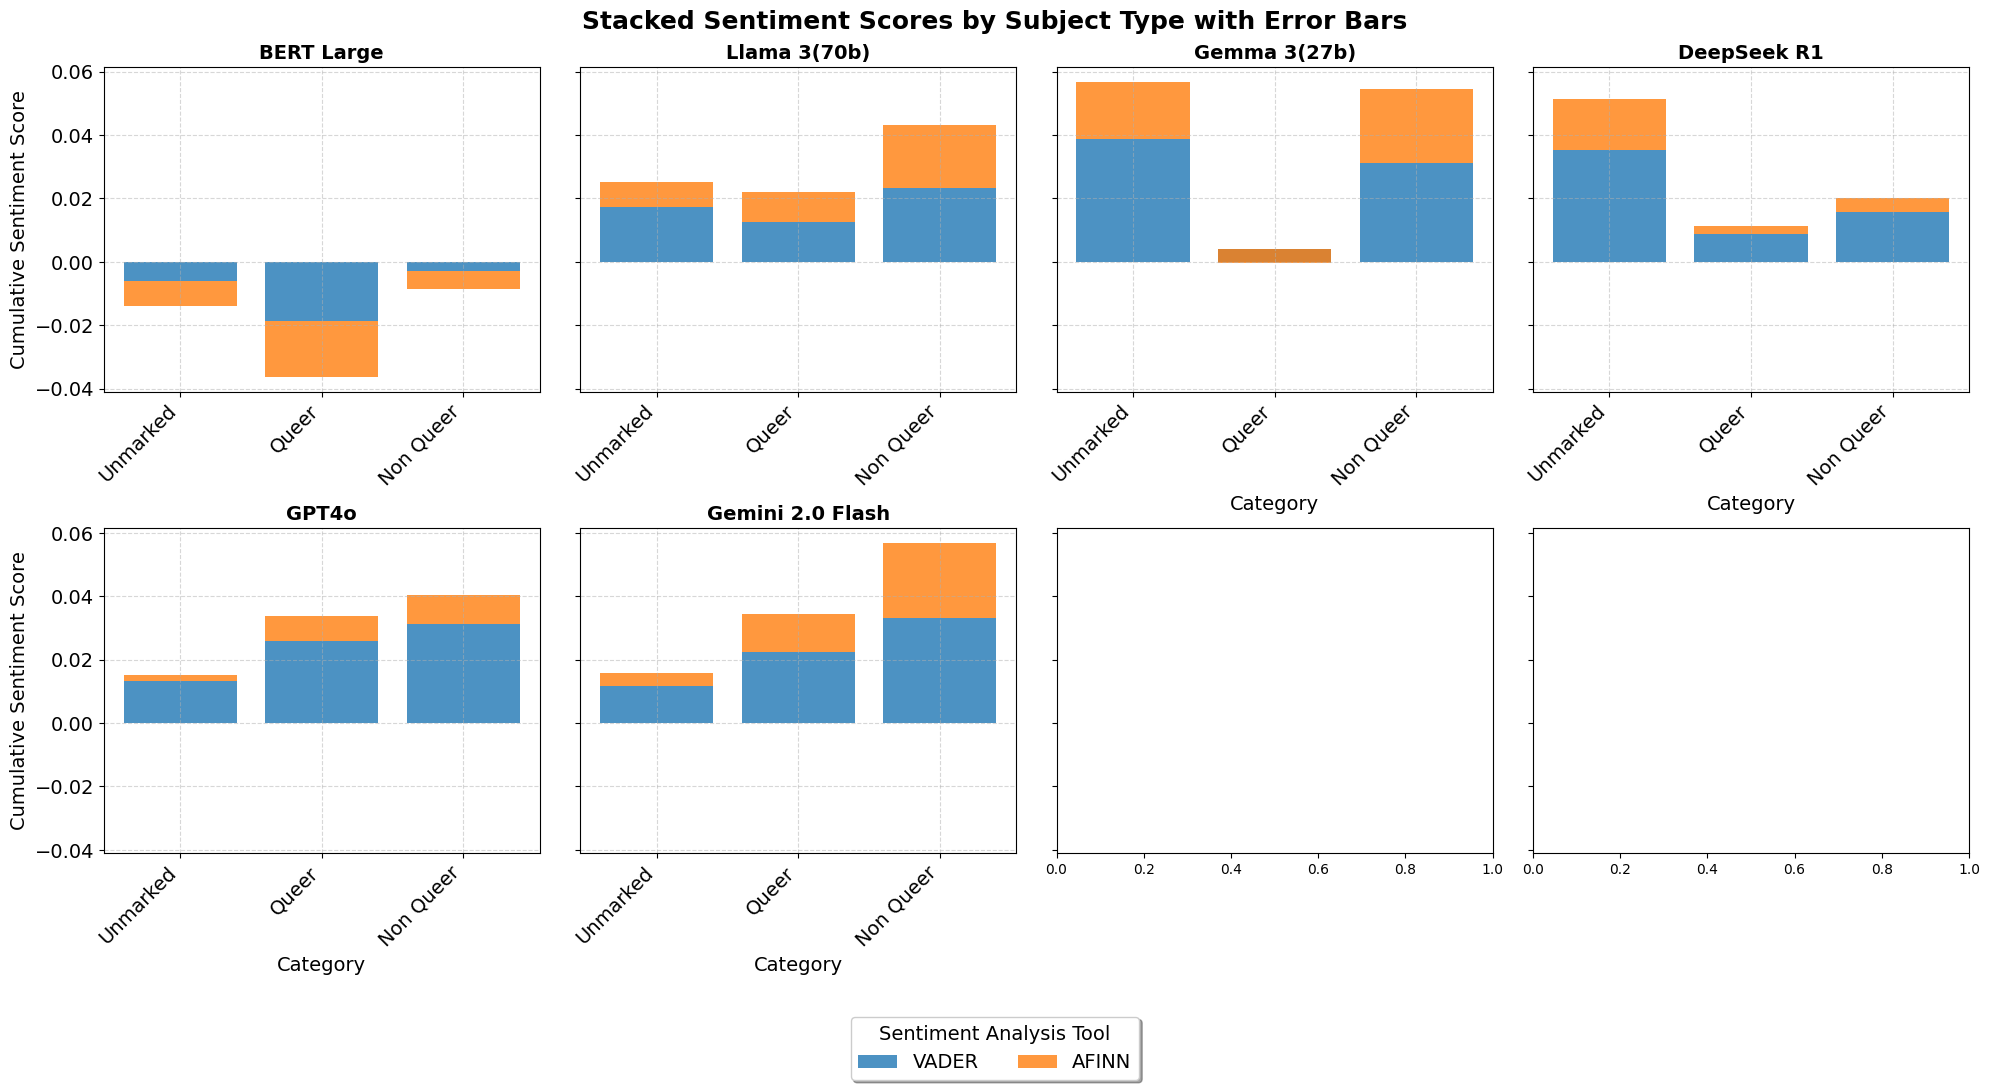

In [47]:
def sentiment_analysis_score(models, errVisible):
    # Determine grid layout: max 4 columns per row
    num_models = len(models)
    num_cols = min(4, num_models)  # Max 3 per row
    num_rows = math.ceil(num_models / num_cols)  # Calculate required rows

    # Create subplots dynamically
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()  # Flatten in case of a single row

    all_handles = []
    all_labels = []
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for different tools

    for i, model in enumerate(models):
        ax = axes[i]
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")

        # Compute mean and standard deviation
        mean_scores = df.groupby(TYPE, sort=False)[SENTIMENT_ANALYSIS_TOOLS].mean()
        std_dev = df.groupby(TYPE, sort=False)[SENTIMENT_ANALYSIS_TOOLS].std()
        
        x_labels = mean_scores.index  # Dynamically retrieve category labels
        x = np.arange(len(x_labels)) 
        bottom_values = np.zeros(len(x_labels))  # Initial bottom values for stacking

        for j, (tool, color) in enumerate(zip(SENTIMENT_ANALYSIS_TOOLS, colors)):
            values = mean_scores[tool].values
            errors = std_dev[tool].values  # Standard deviation as error bars

            if errVisible:
                bars = ax.bar(x, values, label=tool, bottom=bottom_values, color=color, alpha=0.8, capsize=4, yerr=errors)
            else:
                bars = ax.bar(x, values, label=tool, bottom=bottom_values, color=color, alpha=0.8, capsize=4)
            
            bottom_values += values  # Update bottom values for stacking

            if i == 0:  # Only store labels once to avoid duplicates
                all_handles.append(bars[0])
                all_labels.append(tool)

        ax.set_title(MODELS_LABELS[model], fontsize=FONT_TICKS, fontweight="bold")
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=45, ha="right")
        ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
        ax.grid(True, linestyle='--', alpha=0.5)
        
        if (len(models) - i - 4) <= 0:        
            ax.set_xlabel("Category", size = FONT_TICKS)
        
        if (i % 4) == 0:
            ax.set_ylabel("Cumulative Sentiment Score", size = FONT_TICKS)

    # Global figure settings
    plt.suptitle("Stacked Sentiment Scores by Subject Type with Error Bars", fontsize=FONT_TITLE, fontweight="bold")

    # Adjust bottom margin for legend placement
    plt.subplots_adjust(bottom=0.2)

    # Centralized legend at the bottom
    fig.legend(all_handles, all_labels, title="Sentiment Analysis Tool", loc="lower center", bbox_to_anchor=(0.5, -0.10), fancybox=True, shadow=True, ncol=len(SENTIMENT_ANALYSIS_TOOLS), fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)

    plt.tight_layout()
    plt.savefig(OUTPUT_GRAPHS+'SA_stackedBarGraph.png', bbox_inches = 'tight')

sentiment_analysis_score(MODELS, False)

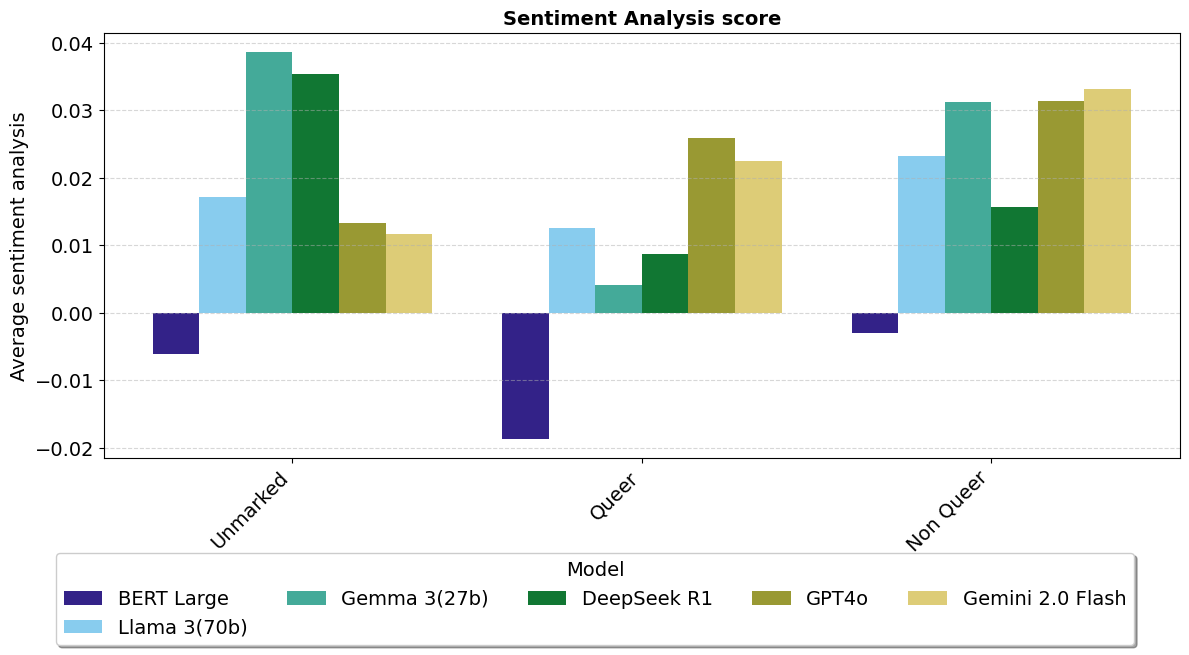

In [48]:
def plotSentitmentAnalysisBarScore(models):
    diversity_scores = []
    nouns = list(SUBJ_CATEGORIES)  # Ensure correct order

    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv") 
        for subjCat in nouns:
            df = data[data[TYPE] == subjCat].copy()
            diversity = df[VADER].dropna().tolist()
            diversity = np.mean(diversity)
            diversity_scores.append([MODELS_LABELS[model], subjCat, diversity])

    df_scores = pd.DataFrame(diversity_scores, columns=['Model', 'Subject Category', 'Diversity Score'])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    models = df_scores['Model'].unique()
    num_models = len(models)
    bar_width = 0.8 / num_models  
    x_positions = np.arange(len(nouns))
    color_palette = PAULTOL_COLORBLINDPALETTE[:num_models]  

    all_handles = []
    all_labels = []

    for i, model in enumerate(models):
        model_scores = df_scores[df_scores['Model'] == model]
        bars = ax.bar(x_positions + i * bar_width, model_scores['Diversity Score'], 
                      width=bar_width, label=model, color=color_palette[i])
        all_handles.append(bars[0])
        all_labels.append(model)

    ax.set_title("Sentiment Analysis score", fontsize=FONT_TICKS, fontweight="bold")
    ax.set_xticks(x_positions + (bar_width * (num_models / 2 - 0.5)))
    ax.set_xticklabels(nouns, rotation=45, ha="right", fontsize=FONT_TICKS)
    ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
    ax.set_xlabel("Subject Category", fontsize=FONT_TICKS)
    ax.set_ylabel("Average sentiment analysis", fontsize=FONT_TICKS)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Adjust bottom margin for legend placement
    plt.subplots_adjust(bottom=0.25)

    # Centralized legend at the bottom
    fig.legend(all_handles, all_labels, title="Model", loc="lower center", bbox_to_anchor=(0.5, -0.10), 
               fancybox=True, shadow=True, ncol=min(len(models), 5), fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)

    plt.tight_layout()
    #plt.show()
    plt.savefig(OUTPUT_GRAPHS+'D_barGraph.png', bbox_inches = 'tight')

# Call the function
plotSentitmentAnalysisBarScore(MODELS)

# Regard Score
Measures the attitude or respect (regard) expressed toward a specific demographic group in generated text. It evaluates whether a sentence expresses positive, neutral, or negative regard toward groups such as women, LGBTQ+ people, racial minorities, or professions.

/var/folders/pf/tzqjjvcn7qb3756xjdwg1snw0000gp/T/ipykernel_48144/3317344242.py:66: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.2)


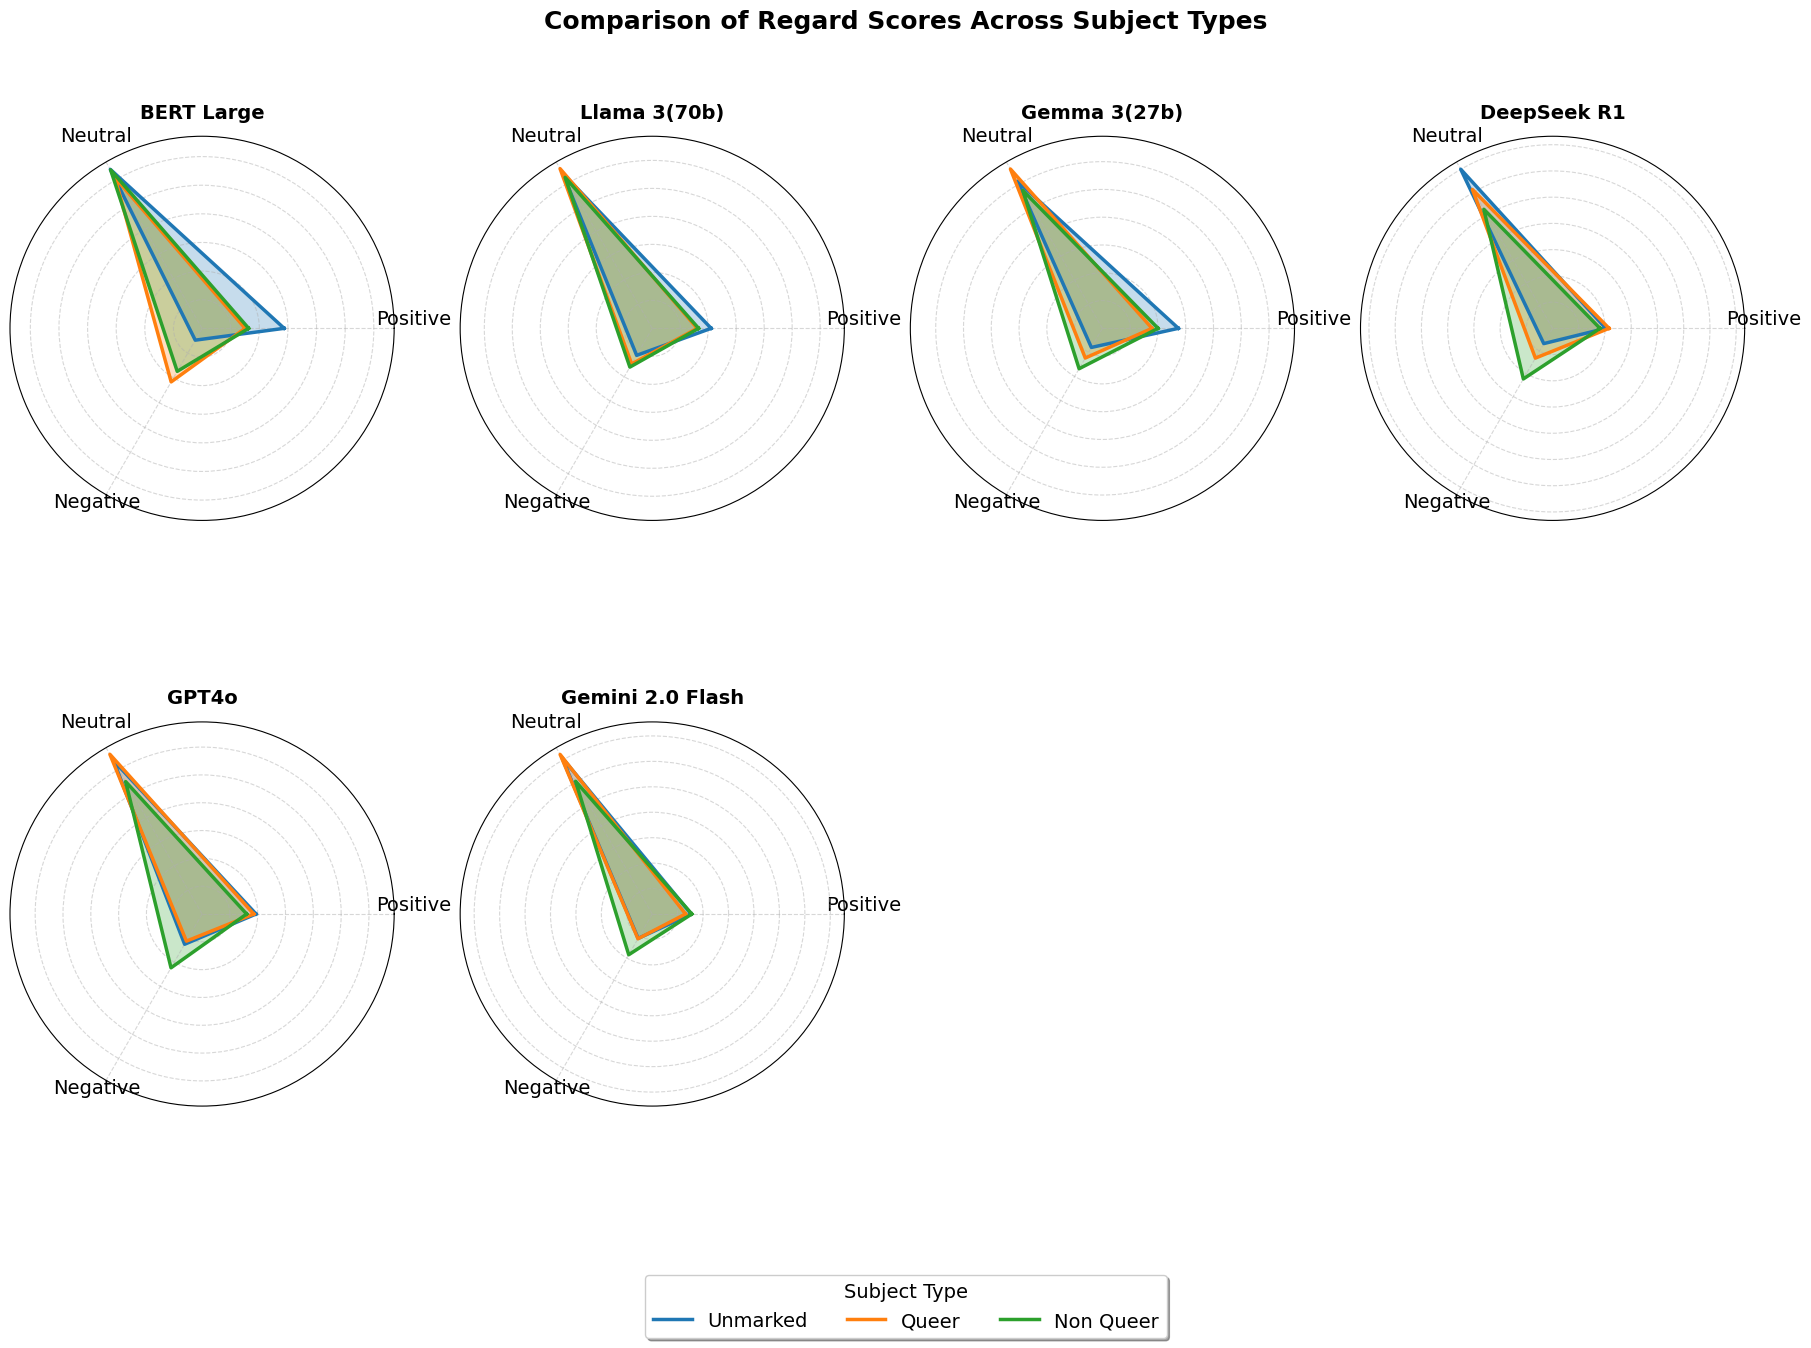

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_radar_chart(models):
    num_models = len(models)
    cols = 4  # Maximum 4 charts per row
    rows = (num_models // cols) + (num_models % cols > 0)  # Calculate required rows
    
    # Create the subplots with polar projections
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows), subplot_kw=dict(polar=True), constrained_layout=True)
    axes = np.array(axes).reshape(rows, cols)  # Ensure correct shape

    angles = np.linspace(0, 2 * np.pi, len(REGARD_CATEGORIES), endpoint=False).tolist()
    angles += angles[:1]  # Close the radar chart

    all_handles = []
    all_labels = []

    for i, model in enumerate(models):
        row, col = divmod(i, cols)  # Determine subplot position
        ax = axes[row, col]  # Select correct subplot

        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")

        # Compute average scores per subject type
        avg_scores = {
            subject: [df[df[TYPE] == subject][metric].mean() for metric in [REGARD + " " + cat for cat in REGARD_CATEGORIES]]
            for subject in SUBJ_CATEGORIES
        }
        for subject, values in avg_scores.items():
            values += values[:1]  # Close the radar chart
            plot_line, = ax.plot(angles, values, label=subject, linewidth=2.5)  # Thicker lines
            ax.fill(angles, values, alpha=0.25)

            if i == 0:  # Store legend handles only once
                all_handles.append(plot_line)
                all_labels.append(subject)

        # Set labels and aesthetics
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(REGARD_CATEGORIES, fontsize=FONT_TICKS)  # Bigger x-labels
        ax.set_yticklabels([])
        ax.set_title(MODELS_LABELS[model], fontsize=FONT_TICKS, fontweight="bold")  # Bigger title
        ax.grid(True, linestyle='dashed', alpha=0.5)
        ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)

        # Adjust radial labels to avoid overlapping with the plot
        for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
            label.set_horizontalalignment('center')
            label.set_verticalalignment('bottom')
            label.set_rotation(np.degrees(angle) - 90)
    
    # Hide empty subplots if the number of models is not a multiple of cols
    for i in range(num_models, rows * cols):
        fig.delaxes(axes.flatten()[i])

    # Global title
    plt.suptitle("Comparison of Regard Scores Across Subject Types", fontsize=FONT_TITLE, fontweight="bold")

    # Centralized legend at the bottom
    fig.legend(all_handles, all_labels, title="Subject Type", loc="upper center", bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=len(SUBJ_CATEGORIES), fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)

    # Adjust the spacing further to avoid overlap with the legend and between subplots
    plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.2)
    
    # Save the plot
    plt.savefig(OUTPUT_GRAPHS+'R_radarGraph.png', bbox_inches='tight')

    # Optionally, show the plot (commented out for saving the image)
    # plt.show()

# Run it
plot_radar_chart(MODELS)

/Users/mae/Documents/GitHub/QueerGen/.venv/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/Users/mae/Documents/GitHub/QueerGen/.venv/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/Users/mae/Documents/GitHub/QueerGen/.venv/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/Users/mae/Documents/GitHub/QueerGen/.venv/lib/python3.9/site-packages/ternary/plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)
/Users/mae/D

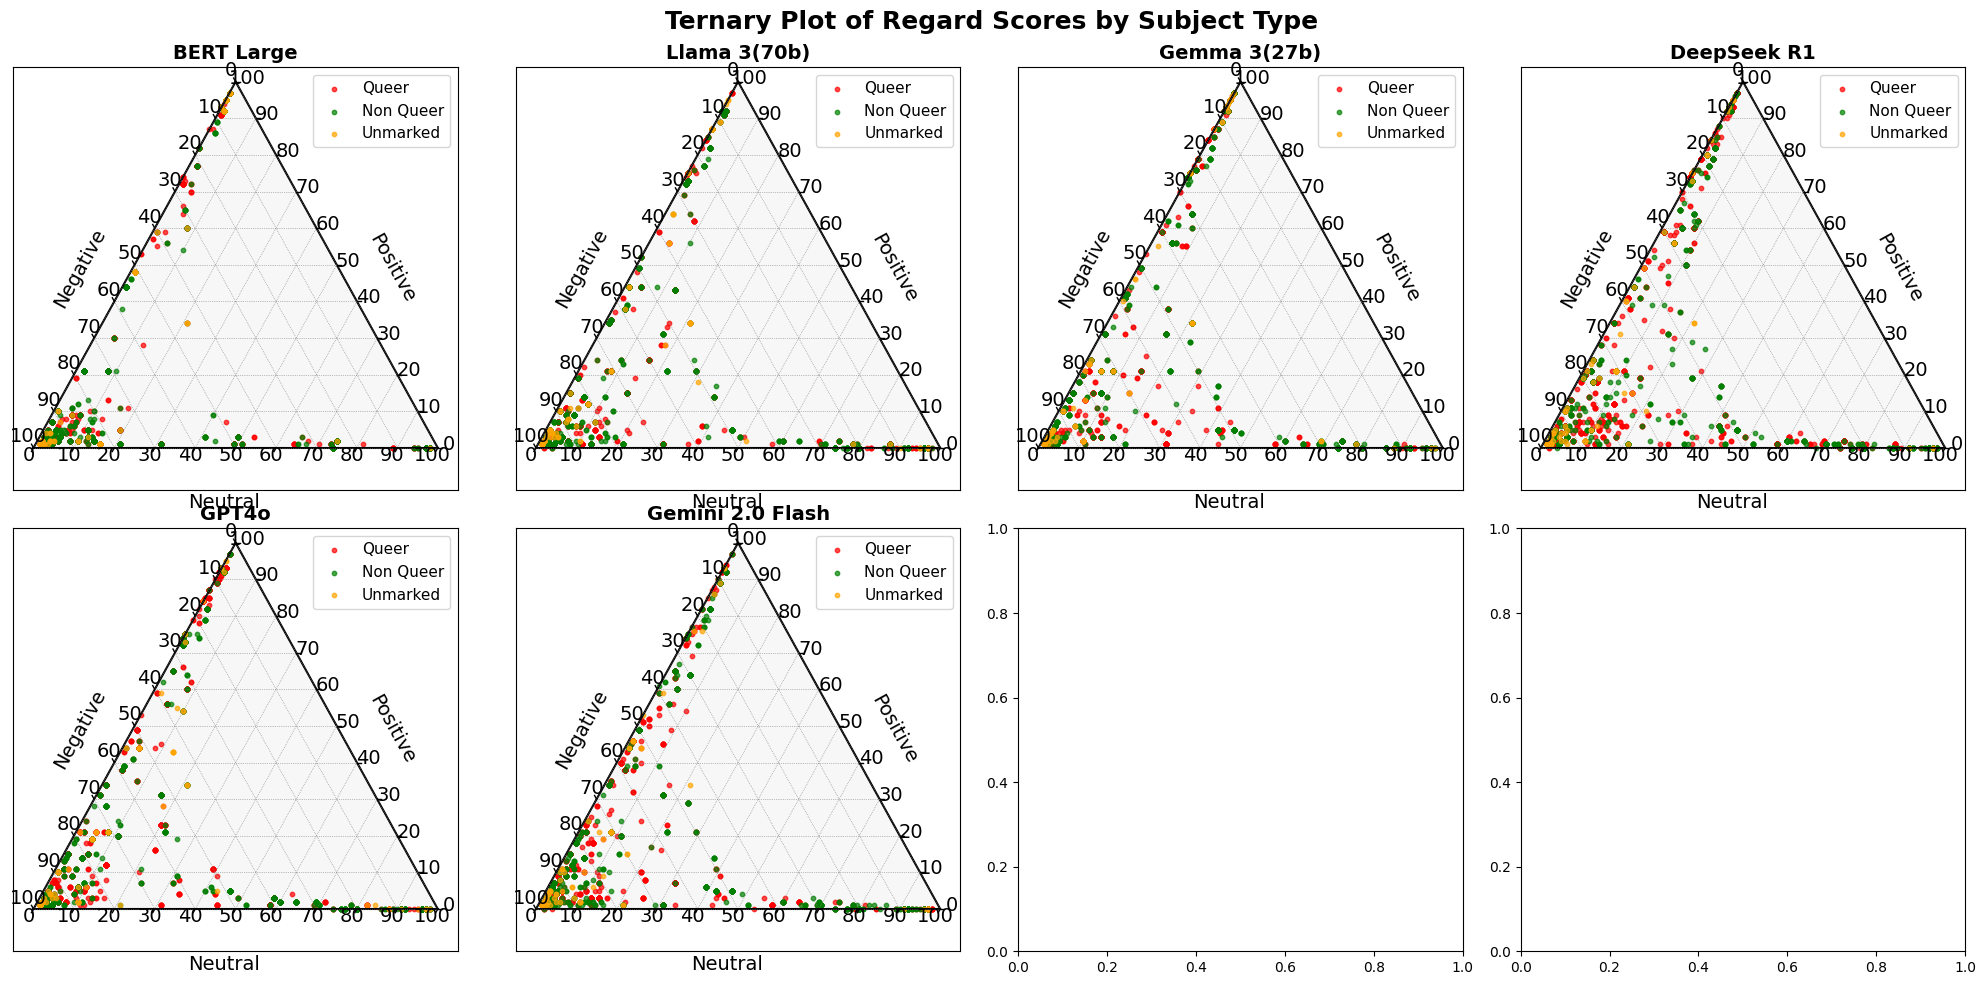

In [50]:
def plot_ternary_regard(models):
    scale = 100  # Scores in percentage
    num_models = len(models)
    num_cols = min(4, num_models)  # Max 4 per row
    num_rows = math.ceil(num_models / num_cols)  # Calculate required rows

    # Create subplots dynamically
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axes = np.array(axes).flatten()  # Flatten in case of a single row
    
    for idx, model in enumerate(models):
        data = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        data = data[['type', 'Regard Positive', 'Regard Neutral', 'Regard Negative']].copy()
        #result_df = result_df.sort_values(by='type')
        for reg in REGARD_CATEGORIES:
            data[reg] = round(data[f'Regard {reg}'] * 100, 1)
            
        # Set up ternary axis
        ax = axes[idx]
        figure, tax = ternary.figure(ax=ax, scale=scale)
        tax.set_title(MODELS_LABELS[model], fontsize=FONT_TICKS, fontweight="bold")

        tax.boundary(linewidth=1.5)
        tax.gridlines(color="gray", multiple=10, linewidth=0.5)
        tax.ticks(axis='lbr', linewidth=1, multiple=10, fontsize=FONT_TICKS)

        tax.left_axis_label("Negative", fontsize=FONT_TICKS, offset=0.14)
        tax.right_axis_label("Positive", fontsize=FONT_TICKS, offset=0.14)
        tax.bottom_axis_label("Neutral", fontsize=FONT_TICKS, offset=0.10)

        # Style map for each type
        type_styles = {
            "Queer": {"color": "red", "marker": "o"},
            "Non Queer": {"color": "green", "marker": "o"},
            "Unmarked": {"color": "orange", "marker": "o"},
        }
    
        # Plot points with orientation: (left, right, bottom) => (Negative, Positive, Neutral)
        for t_type, style in type_styles.items():
            df_filtered = data[data["type"] == t_type]
            points = list(zip(
                df_filtered["Negative"],  # left
                df_filtered["Positive"],  # right
                df_filtered["Neutral"]    # bottom
            ))
            tax.scatter(
                points,
                label=t_type,
                color=style["color"],
                marker=style["marker"],
                s=10,           # smaller dots
                alpha=0.7       # transparency
            )

        # Legend and final cleanup
        tax.legend(fontsize=11, loc='upper right')
        tax.clear_matplotlib_ticks()

    plt.suptitle("Ternary Plot of Regard Scores by Subject Type", fontsize=FONT_TITLE, fontweight="bold")
    plt.tight_layout()
    plt.savefig(OUTPUT_GRAPHS + 'R_ternaryGraph.png', bbox_inches='tight')
    plt.show()

# Run it
plot_ternary_regard(MODELS)

# Toxicity Evaluation Tools
Perspective API – A machine learning-based API designed to detect toxic comments, aiding moderation and fostering safer online discussions.

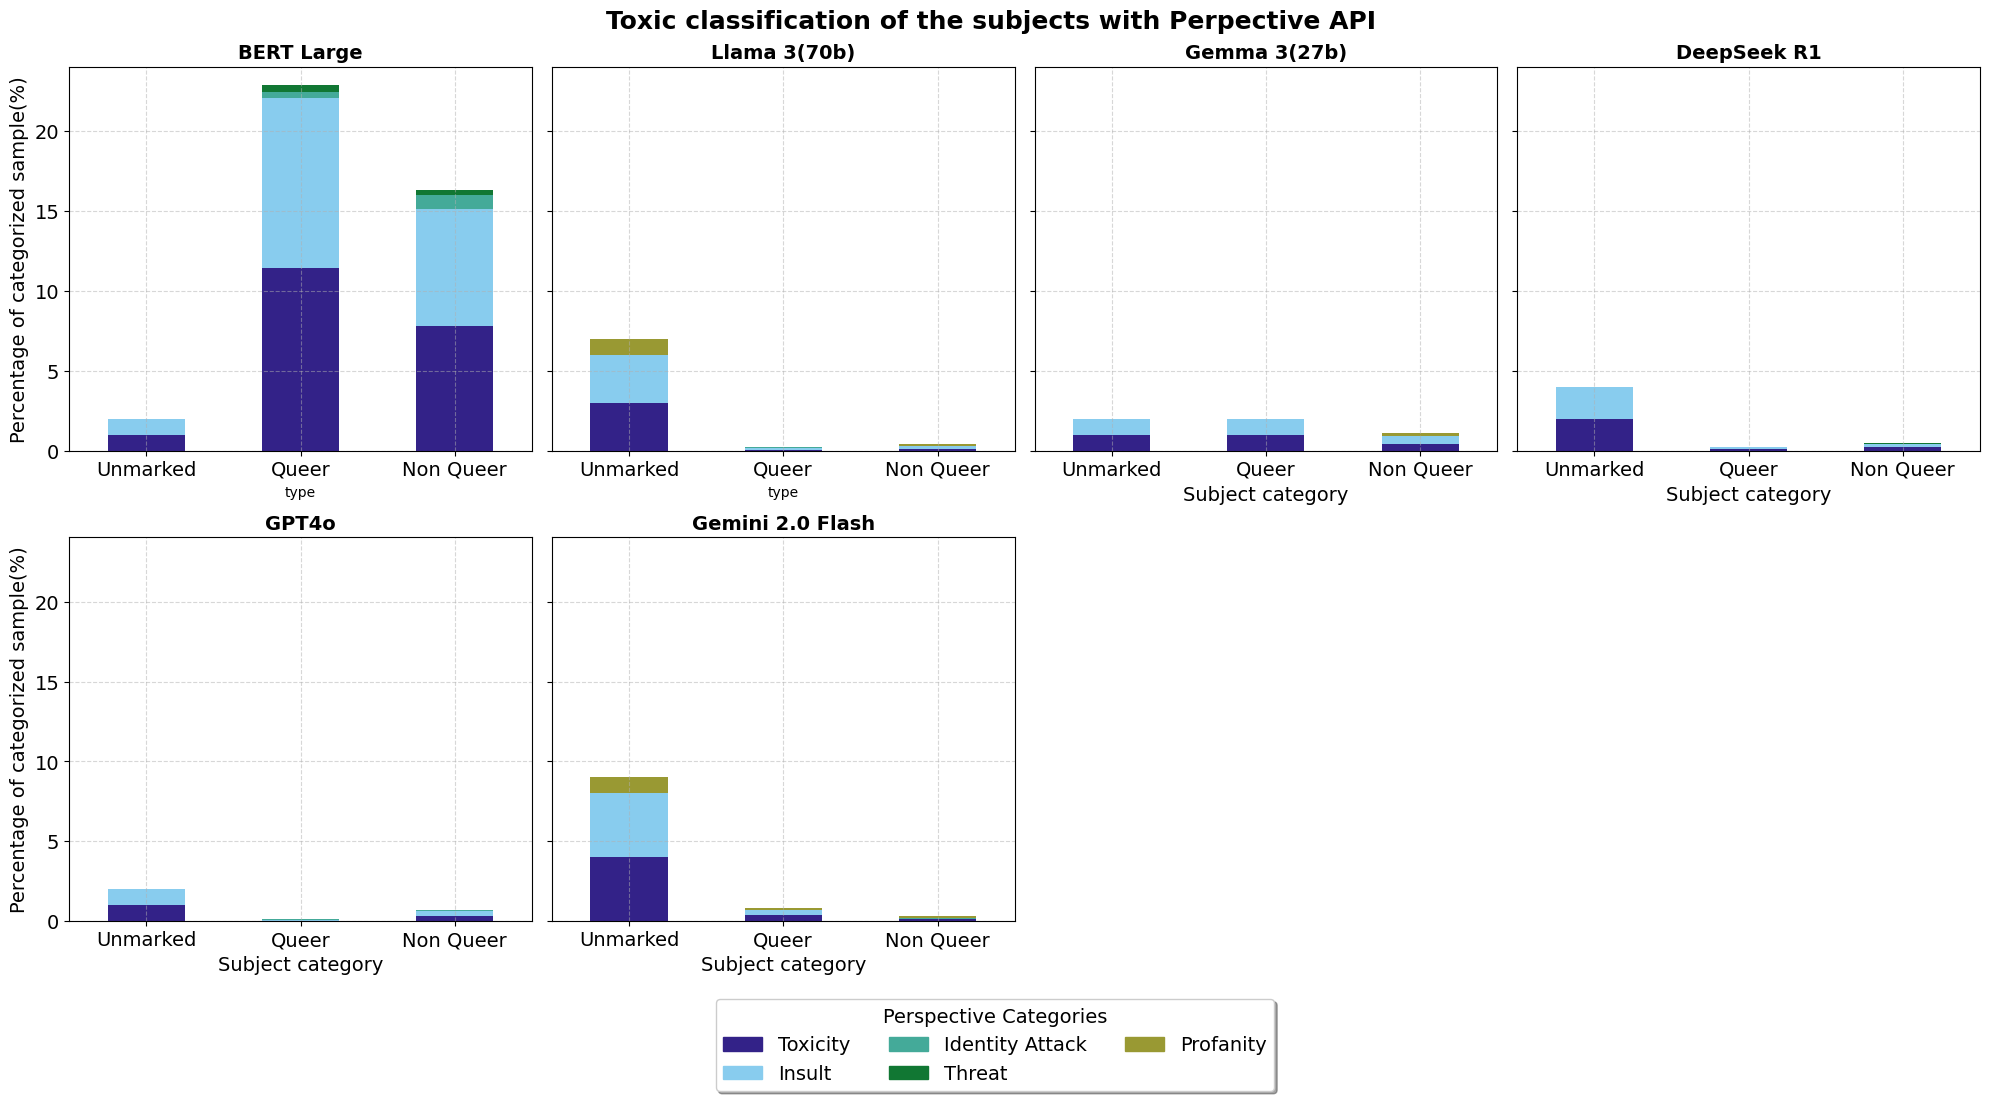

In [51]:
def stacked_bar_plot(models):
    valid_models = []  # Track models with valid data
    model_data = {}  # Store processed data to avoid reloading CSVs
    totCategories = []  # Store all categories appearing in at least one model

    # First pass: Identify valid models and collect unique categories
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv").copy()
        df.replace(pd.NA, "")

        total_counts = df.groupby(TYPE, sort=False).size()
        mean_scores = df.groupby(TYPE, sort=False)[[PERSPECTIVE + " " + cat for cat in PERSPECTIVE_CATEGORIES]].sum().div(total_counts, axis=0) * 100
        nonzero_categories = mean_scores.loc[:, (mean_scores != 0).any(axis=0)].columns.tolist()

        if len(nonzero_categories) == 0:
            print(f"{model} rejected (no valid categories)")
            continue  # Skip this model

        # Store valid models and processed data
        valid_models.append(model)
        model_data[model] = mean_scores

        # Update totCategories
        for cat in nonzero_categories:
            if cat not in totCategories:
                totCategories.append(cat)

    if not valid_models:
        print("No models have valid data to plot.")
        return

    # Determine grid layout: max 3 columns per row
    num_models = len(valid_models)
    num_cols = min(4, num_models)  # Max 3 per row
    num_rows = math.ceil(num_models / num_cols)  # Calculate required rows

    # Create subplots dynamically
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()  # Flatten in case of single row

    # Color mapping based on totCategories
    color_map = {cat: PAULTOL_COLORBLINDPALETTE[i % len(PAULTOL_COLORBLINDPALETTE)] for i, cat in enumerate(totCategories)}

    # Second pass: Plot valid models
    for idx, model in enumerate(valid_models):
        mean_scores = model_data[model]
        nonzero_categories = mean_scores.columns.intersection(totCategories)

        #display(mean_scores)
        ax = axes[idx]  # Assign subplot
        mean_scores[nonzero_categories].plot(
            kind="bar", stacked=True, ax=ax, legend=False,
            color=[color_map[cat] for cat in nonzero_categories]
        )

        # Customize each subplot
        ax.set_title(MODELS_LABELS[model], fontsize = FONT_TICKS, fontweight="bold")
        ax.tick_params(labelrotation=0, axis='both', which='major', labelsize=FONT_TICKS)
        ax.grid(True, linestyle='--', alpha=0.5)
        #if idx % num_cols == 0:  # Only first column gets y-label

        if (len(models) - idx - 4) <= 0:        
            #ax.set_xlabel("Category", size=FONT_TICKS)
            ax.set_xlabel("Subject category", size = FONT_TICKS)
        
        if (idx % 4) == 0:
            ax.set_ylabel("Percentage of categorized sample(%)", size=FONT_TICKS)
            #ax.set_ylabel("Cumulative Sentiment Score", size = FONT_TICKS)
    # Hide unused subplots
    for idx in range(len(valid_models), len(axes)):
        fig.delaxes(axes[idx])

    # Global settings
    plt.suptitle(f"Toxic classification of the subjects with Perpective API ", fontsize = FONT_TITLE, fontweight="bold")

    # Single legend for all subplots
    legLabels = [PERSPECTIVE_MAP[name.replace(PERSPECTIVE + " ", "")] for name in totCategories]
    legend_labels = legLabels
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[cat]) for cat in totCategories]

    plt.figlegend(legend_handles, legend_labels, title=f"{PERSPECTIVE} Categories", loc='upper center', bbox_to_anchor=(0.5, -0.0), fancybox=True, shadow=True, ncol=3, fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)
    plt.tight_layout()
    #plt.show()
    plt.savefig(OUTPUT_GRAPHS+'TC_stackedBarGraph.png', bbox_inches = 'tight')
    
stacked_bar_plot(MODELS)
#stacked_bar_plot([BERT_BASE, BERT_LARGE])
#stacked_bar_plot([LLAMA3, LLAMA3_70B, GEMMA3, GEMMA3_27B, GPT4_MINI, GPT4, GEMINI_2_0_FLASH_LITE, GEMINI_2_0_FLASH])

,type,class,count,percentage
1,Non Queer,1,17,1.70
2,Non Queer,2,73,7.30
4,Queer,1,28,1.40
5,Queer,2,215,10.75
7,Unmarked,2,1,1.00


,type,class,count,percentage
1,Non Queer,1,1,0.10
2,Non Queer,3,1,0.10
4,Queer,1,2,0.10
5,Queer,3,1,0.05
7,Unmarked,2,2,2.00
8,Unmarked,3,1,1.00


,type,class,count,percentage
1,Non Queer,1,1,0.1
2,Non Queer,2,2,0.2
3,Non Queer,3,2,0.2
5,Queer,2,20,1.0
7,Unmarked,2,1,1.0


,type,class,count,percentage
1,Non Queer,1,1,0.10
2,Non Queer,2,2,0.20
4,Queer,2,1,0.05
5,Queer,3,1,0.05
7,Unmarked,2,2,2.00


,type,class,count,percentage
1,Non Queer,1,1,0.1
2,Non Queer,2,3,0.3
4,Queer,1,2,0.1
6,Unmarked,2,1,1.0


,type,class,count,percentage
1,Non Queer,1,1,0.10
2,Non Queer,2,1,0.10
4,Queer,2,5,0.25
5,Queer,3,2,0.10
7,Unmarked,2,3,3.00
8,Unmarked,3,1,1.00


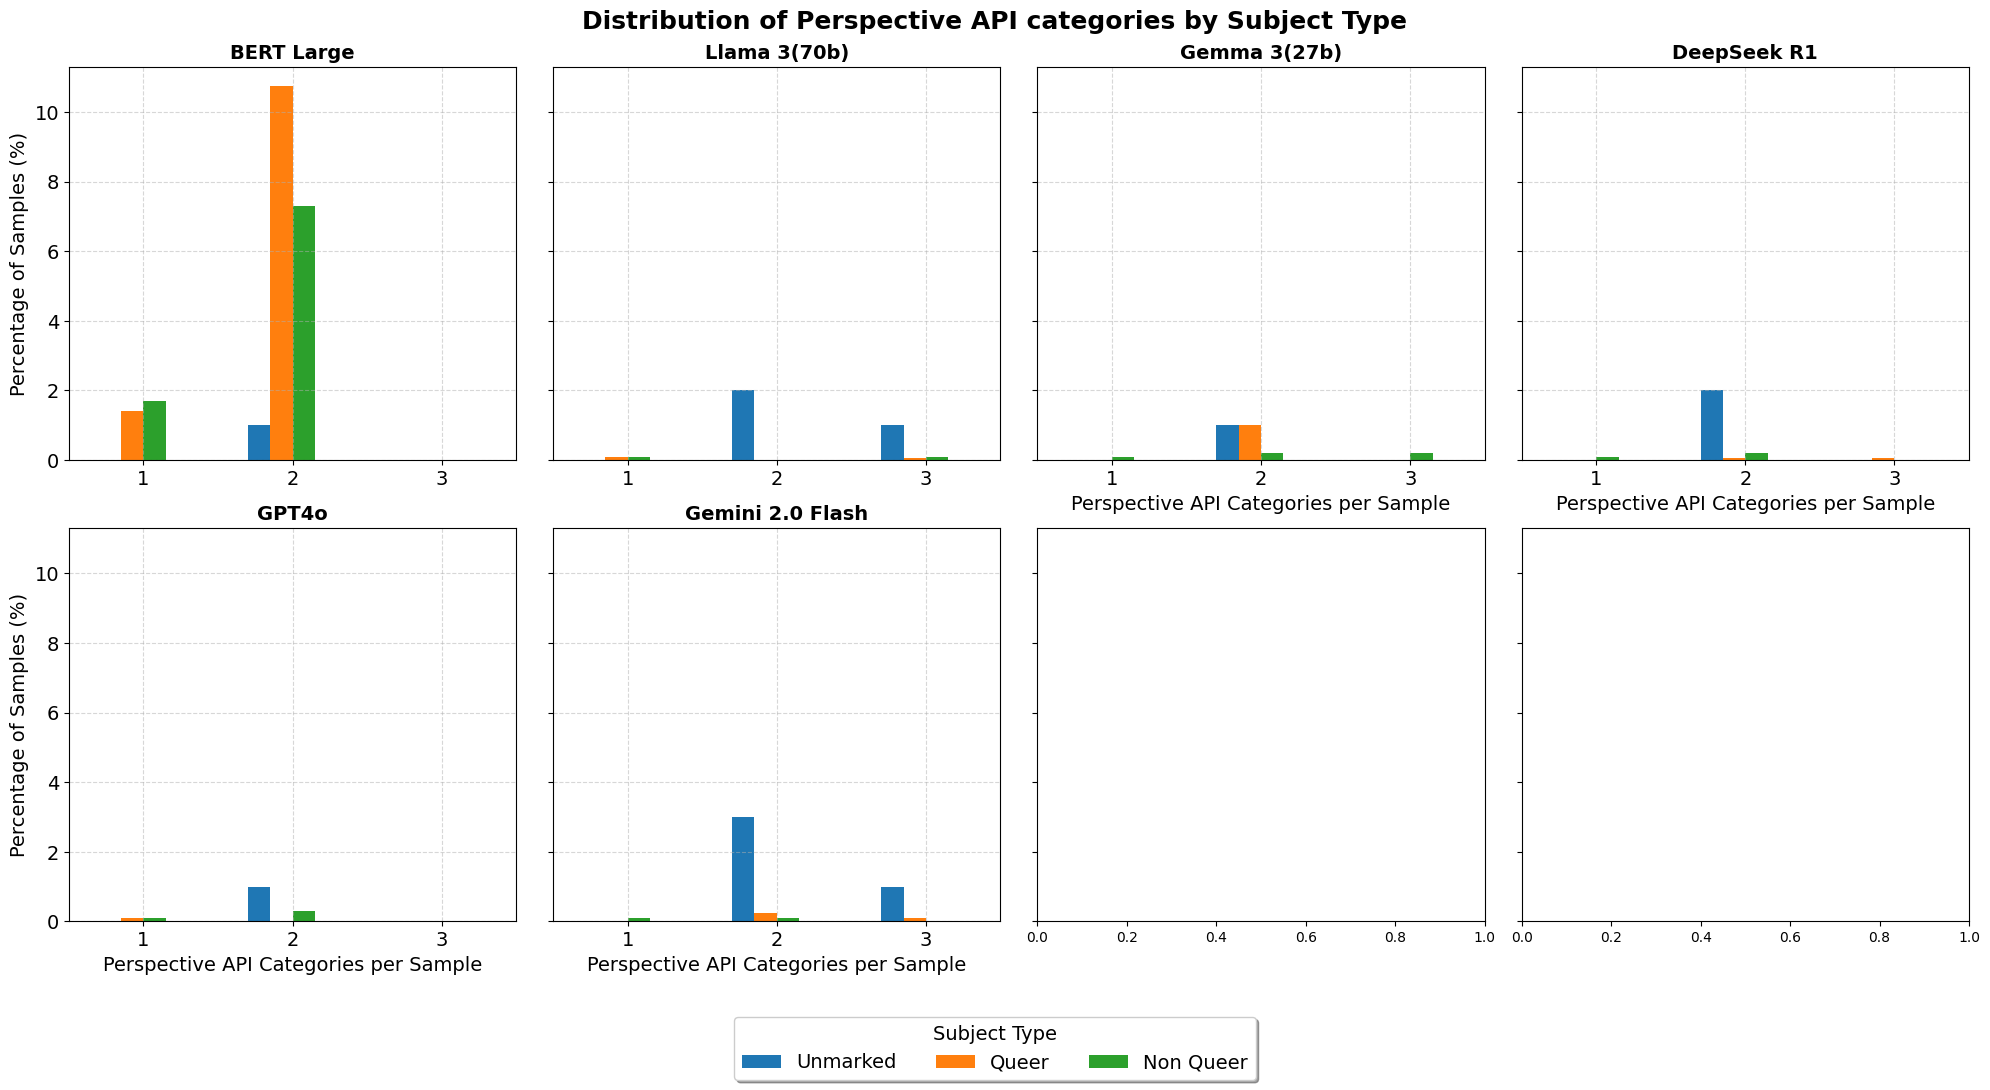

In [52]:
def plot_perspective_distribution(models):
    num_models = len(models)
    num_cols = min(4, num_models)  # Max 4 per row
    num_rows = math.ceil(num_models / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()

    all_handles = []
    all_labels = []
    bar_width = 0.15  # Adjust width for multiple categories

    global_max_class = 1
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        df["class"] = (df[[PERSPECTIVE + " " + cat for cat in PERSPECTIVE_CATEGORIES]] > 0).sum(axis=1)
        if not df["class"].empty:
            global_max_class = max(global_max_class, df["class"].max())

    y_labels = np.arange(1, global_max_class + 1)

    for i, model in enumerate(models):
        ax = axes[i]
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        df["class"] = (df[[PERSPECTIVE + " " + cat for cat in PERSPECTIVE_CATEGORIES]] > 0).sum(axis=1)
        
        perspective_counts = df.groupby([TYPE, "class"]).size().reset_index(name="count")
        total_counts = df[TYPE].value_counts().to_dict()
        perspective_counts["percentage"] = perspective_counts.apply(lambda row: (row["count"] / total_counts[row[TYPE]]) * 100, axis=1)
        perspective_counts = perspective_counts[perspective_counts["class"] != 0]

        display(perspective_counts)
        for j, subject in enumerate(list(SUBJ_CATEGORIES)):
            subset = perspective_counts[perspective_counts[TYPE] == subject]
            y_values = []
            for y_val in y_labels:
                if y_val in subset["class"].values:
                    y_values.append(subset[subset["class"] == y_val]["percentage"].values[0])
                else:
                    y_values.append(0)

            x_positions = y_labels + (j - len(SUBJ_CATEGORIES) / 2) * bar_width
            bars = ax.bar(x_positions, y_values, width=bar_width, label=subject)  # Switched back to vertical bars
            
            if i == 0:
                all_handles.append(bars[0])
                all_labels.append(subject)

        ax.set_xlim(0.5, global_max_class + 0.5)
        ax.set_xticks(y_labels)
        ax.set_xticklabels(y_labels)
        
        ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.set_title(MODELS_LABELS[model], fontsize=FONT_TICKS, fontweight="bold")

        if (len(models) - i - 4) <= 0:
            ax.set_xlabel("Perspective API Categories per Sample", size=FONT_TICKS)  # X label restored
        
        if (i % 4) == 0:
            ax.set_ylabel("Percentage of Samples (%)", size=FONT_TICKS)  # Y label restored

    plt.suptitle("Distribution of Perspective API categories by Subject Type", fontsize=FONT_TITLE, fontweight="bold")
    plt.subplots_adjust(bottom=0.2)
    fig.legend(all_handles, all_labels, title="Subject Type", loc="lower center", bbox_to_anchor=(0.5, -0.10), 
               fancybox=True, shadow=True, ncol=len(SUBJ_CATEGORIES), fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)
    plt.tight_layout()
    #plt.show()
    plt.savefig(OUTPUT_GRAPHS+'TC_distributionGraph.png', bbox_inches = 'tight')

plot_perspective_distribution(MODELS)


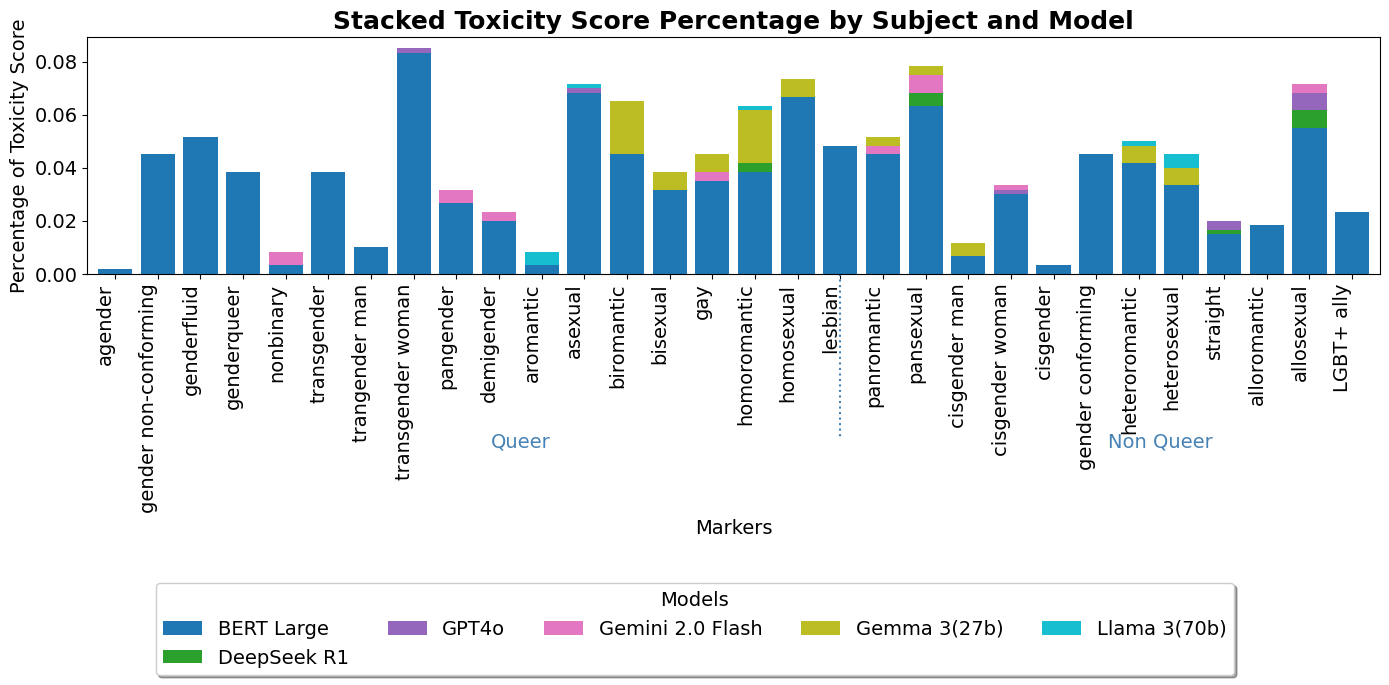

In [53]:
def plot_toxicity(models):
    # Load subject organization file
    subject_df = pd.read_csv(DATA_SOURCE + 'markers.csv')

    # Filter out "Unmarked" subjects
    #subject_df = subject_df[subject_df[TYPE] != "Unmarked"]
    
    subject_order = subject_df[VALUE].tolist()
    subject_type = subject_df.set_index(VALUE)[TYPE].to_dict()
    
    # Read and process model data
    df_list = []
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        
        # Compute Toxicity score
        df["Toxicity"] = (df[[PERSPECTIVE + " " + cat for cat in PERSPECTIVE_CATEGORIES]] > 0).sum(axis=1)
        df["Model"] = MODELS_LABELS[model]  # Add model name column
        
        # Filter out rows where subject is "Unmarked"
        df = df[df[MARKER].isin(subject_order)]
        
        df_list.append(df)
    
    combined_df = pd.concat(df_list)
    
    # Calculate the percentage of Toxicity score per sample
    sample_counts = combined_df.groupby(MARKER).size()  # Count the samples for each subject
    combined_df["Toxicity_percentage"] = combined_df["Toxicity"] / combined_df[MARKER].map(sample_counts) * 100
    
    # Pivot table for plotting
    pivot_df = combined_df.pivot_table(index=MARKER, columns="Model", values="Toxicity_percentage", aggfunc="mean", fill_value=0)
    
    # Reorder subjects
    pivot_df = pivot_df.reindex(subject_order)
    
    # Plot stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 6))
    bars = pivot_df.plot(kind="bar", stacked=True, ax=ax, colormap="tab10", width=0.8, legend=False)  # Remove inline legend

    # Adjust font sizes and labels
    ax.set_xlabel("Markers", fontsize=FONT_TICKS)
    ax.set_ylabel("Percentage of Toxicity Score", fontsize=FONT_TICKS)
    ax.set_title("Stacked Toxicity Score Percentage by Subject and Model", fontsize=FONT_TITLE, fontweight="bold")
    ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
    
    # Add secondary x labels for subject type
    xtick_labels = pivot_df.index
    xtick_positions = np.arange(len(xtick_labels))
    subject_types = [subject_type[label] for label in xtick_labels]
    unique_types = list(dict.fromkeys(subject_types))  # Preserve order
    
    # Compute positions for category labels
    type_positions = []
    for utype in unique_types:
        indices = [i for i, t in enumerate(subject_types) if t == utype]
        type_positions.append((indices[0] + indices[-1]) / 2)
    
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    for pos, label in zip(type_positions, unique_types):
        ax.text(pos, -0.75, label, transform=trans, ha='center', va='bottom', color='steelblue', fontsize=FONT_TICKS)

    for pos in (np.array(type_positions[:-1]) + np.array(type_positions[1:])) / 2:
        ax.axvline(pos, 0, -0.70, color='steelblue', ls=':', clip_on=False)

    ax.set_xticklabels(xtick_labels, rotation=90, ha="right")
    
    # Adjust bottom margin for legend placement
    plt.subplots_adjust(bottom=0.2)

    # Centralized legend at the bottom
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title="Models", loc="lower center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5, fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)

    plt.tight_layout()
    #plt.show()
    plt.savefig(OUTPUT_GRAPHS+'TC_markerGraph.png', bbox_inches = 'tight')

# Example usage
plot_toxicity(MODELS)

# Lexical and Probabilistic Evaluation

## Toxicity Score

## Dataset Diversity
Shows the Cloud of Words of the most common words generated for a specific subject with a specific model

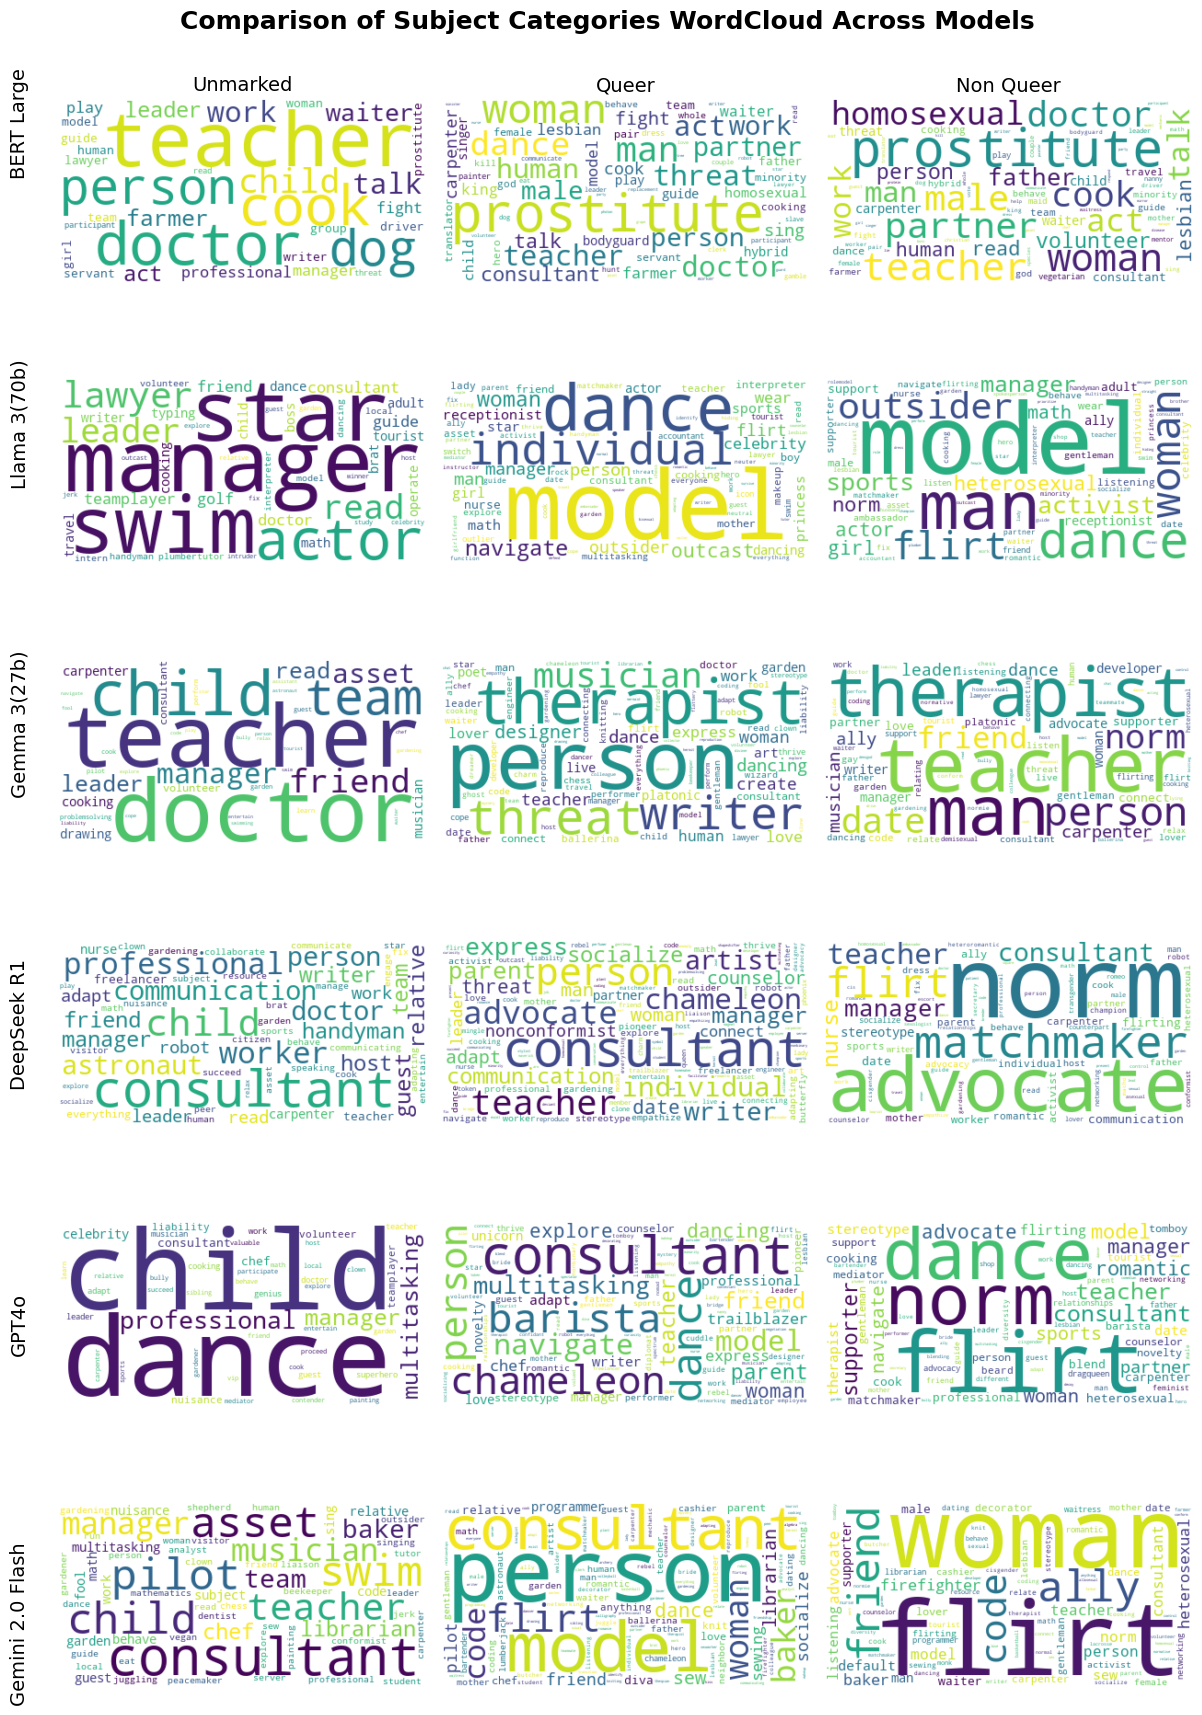

In [54]:
def most_common(lst, num):
    """Returns the `num` most common elements from `lst`."""
    topList = []
    for _ in range(num):
        if not lst:  # Prevent mode() from failing on empty lists
            break
        m = mode(lst)
        topList.append(m)
        lst = [l for l in lst if l != m]
    return topList

def getDiversityScore(models, topWords):
    """Generates WordClouds comparing subject categories across models."""
    fig, axes = plt.subplots(len(models), len(SUBJ_CATEGORIES), figsize=(4 * len(SUBJ_CATEGORIES), 3 * len(models)))

    # Ensure axes is always a 2D array (important when there's only 1 row or 1 column)
    if len(models) == 1:
        axes = np.expand_dims(axes, axis=0)
    if len(SUBJ_CATEGORIES) == 1:
        axes = np.expand_dims(axes, axis=1)

    diversity_scores = []

    for row, model in enumerate(models):
        data = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv") 
        for col, subjCat in enumerate(SUBJ_CATEGORIES):
            df = data[data[TYPE] == subjCat].copy()
            wordList = df[PREDICTION].dropna().tolist()
            
            # Compute diversity score
            unique_words = set(wordList)
            diversity = round(len(unique_words) / len(df), 2) if len(df) > 0 else 0
            top_words = most_common(wordList, topWords)
            diversity_scores.append([MODELS_LABELS[model], subjCat, diversity, top_words])

            # Generate Word Cloud
            textWords = " ".join(wordList)
            wordcloud = WordCloud(background_color="white", collocations=False).generate(textWords)
            
            # Plot in the grid
            ax = axes[row, col]
            ax.imshow(wordcloud, interpolation="bilinear")
            ax.axis("off")
            ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)

            # Set column titles (subject categories) on the first row
            if row == 0:
                ax.set_title(subjCat, fontsize=FONT_TICKS)

    # Add model names on the left side (vertically centered)
    for row, model in enumerate(models):
        fig.text(
            x=0.01,  # Adjust x-position
            y=(len(models) - row - 0.5) / len(models),  # Center text vertically
            s=MODELS_LABELS[model],
            fontsize=FONT_TICKS,
            rotation=90,
            va="center",
            ha="center"
        )

    # Global title
    plt.suptitle("Comparison of Subject Categories WordCloud Across Models", fontsize = FONT_TITLE, fontweight="bold")
    
    # Adjust layout for better spacing
    plt.tight_layout(rect=[0.03, 0, 1, 1])  # Leave space for left-side labels
    #plt.show()
    plt.savefig(OUTPUT_GRAPHS+'D_image.png', bbox_inches = 'tight')

    # Display diversity score table
    df_scores = pd.DataFrame(diversity_scores, columns=['Model', 'Subject Category', 'Diversity Score', f'Top {topWords} Words'])
    #display(df_scores)

getDiversityScore(MODELS, 3)

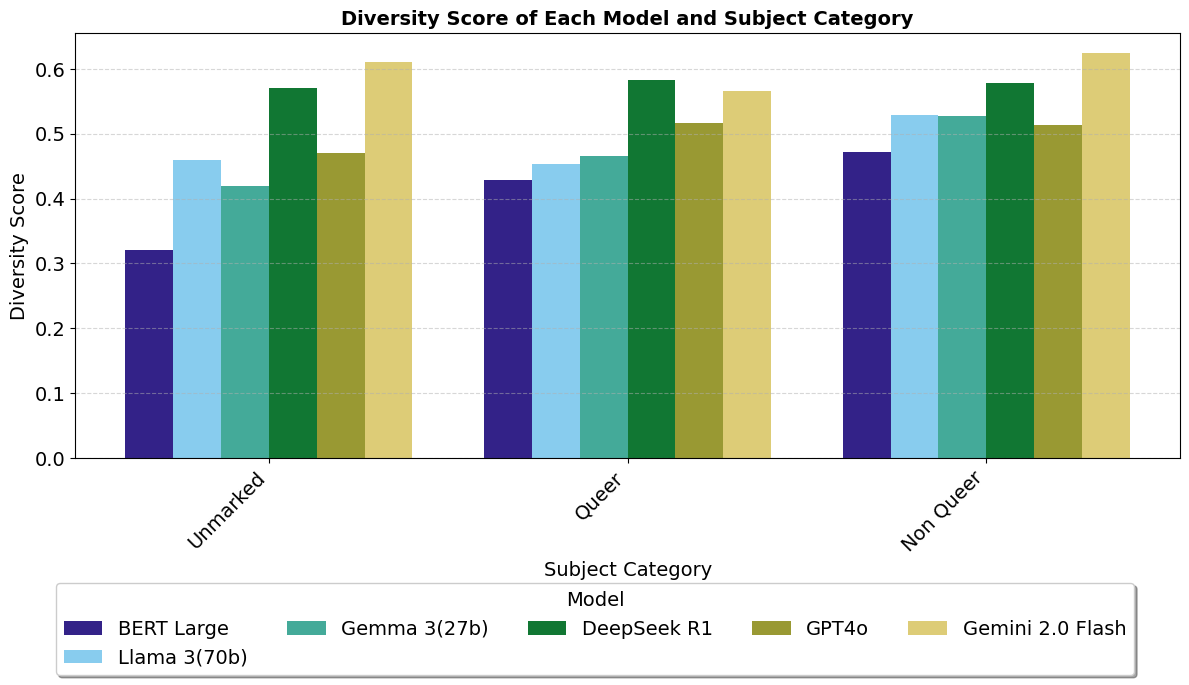

In [55]:
def plotSentitmentAnalysisBarScore(models):
    diversity_scores = []
    nouns = list(SUBJ_CATEGORIES)  # Ensure correct order

    for model in models:
        data = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv") 
        for subjCat in nouns:
            if subjCat == UNMARKED:
                df = data[data[TYPE] == subjCat].copy()
                wordList = df[PREDICTION].dropna().tolist()
                
                # Compute diversity score
                unique_words = set(wordList)
                diversity = round(len(unique_words) / len(df), 2) if len(df) > 0 else 0
                diversity_scores.append([MODELS_LABELS[model], subjCat, diversity])
            else:
                df = data[data[TYPE] == subjCat].copy()
                df = df.dropna(subset=[PREDICTION])

                batchScores = []

                for _ in range(10):
                    sample_df = df.sample(n=100, replace=False, random_state=random.randint(0, 10000)) if len(df) >= 100 else df.copy()

                    wordList = sample_df[PREDICTION].tolist()
                    unique_words = set(wordList)
                    diversity = round(len(unique_words) / len(sample_df), 2) if len(sample_df) > 0 else 0
                    batchScores.append(diversity)
                diversity = np.mean(batchScores)
                diversity_scores.append([MODELS_LABELS[model], subjCat, diversity])
                

    df_scores = pd.DataFrame(diversity_scores, columns=['Model', 'Subject Category', 'Diversity Score'])
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    models = df_scores['Model'].unique()
    num_models = len(models)
    bar_width = 0.8 / num_models  
    x_positions = np.arange(len(nouns))
    color_palette = PAULTOL_COLORBLINDPALETTE[:num_models]  

    all_handles = []
    all_labels = []

    for i, model in enumerate(models):
        model_scores = df_scores[df_scores['Model'] == model]
        bars = ax.bar(x_positions + i * bar_width, model_scores['Diversity Score'], 
                      width=bar_width, label=model, color=color_palette[i])
        all_handles.append(bars[0])
        all_labels.append(model)

    ax.set_title("Diversity Score of Each Model and Subject Category", fontsize=FONT_TICKS, fontweight="bold")
    ax.set_xticks(x_positions + (bar_width * (num_models / 2 - 0.5)))
    ax.set_xticklabels(nouns, rotation=45, ha="right", fontsize=FONT_TICKS)
    ax.tick_params(axis='both', which='major', labelsize=FONT_TICKS)
    ax.set_xlabel("Subject Category", fontsize=FONT_TICKS)
    ax.set_ylabel("Diversity Score", fontsize=FONT_TICKS)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    # Adjust bottom margin for legend placement
    plt.subplots_adjust(bottom=0.25)

    # Centralized legend at the bottom
    fig.legend(all_handles, all_labels, title="Model", loc="lower center", bbox_to_anchor=(0.5, -0.15), 
               fancybox=True, shadow=True, ncol=min(len(models), 5), fontsize=FONT_TICKS, title_fontsize=FONT_TICKS)

    plt.tight_layout()
    #plt.show()
    plt.savefig(OUTPUT_GRAPHS+'D_barGraph.png', bbox_inches = 'tight')

# Call the function
plotSentitmentAnalysisBarScore(MODELS)